In [1]:
!pip install -r ../requirements.txt;
!pip install ipywidgets;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 MB 17.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 53.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 67.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 72.3 MB/s eta 0:00:00


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires keras<2.11,>=2.10.0, but you have keras 2.11.0 which is incompatible.
tensorflow 2.10.0 requires tensorboard<2.11,>=2.10, but you have tensorboard 2.11.0 which is incompatible.
tensorflow 2.10.0 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorfl


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from src import train_split, Scaler, model, RMSE

2022-11-26 18:15:47.767078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 18:15:47.856088: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [306]:
df = pd.read_csv("../data/jobss-processed.csv")

In [312]:
target_col = "sal"
non_target_cols = df.drop(columns=target_col).columns
(train_data, train_labels), (test_data, test_labels) = train_split(df, target_col)

scale_cols = ["Longitude", "Latitude"]
standard_scaler = Scaler(train_data[scale_cols], test_data[scale_cols])
train_data[scale_cols] = standard_scaler.train_scale()
test_data[scale_cols] = standard_scaler.test_scale()

train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

In [ ]:
def k_fold(data:Union[pd.DataFrame, np.array], n_folds:int target:Union[str, int], scaler:class):
    data.shape[0] // n_folds

In [308]:
# # Test

# (train_data, train_labels), (test_data, test_labels) = keras.datasets.boston_housing.load_data(test_split=0.2)

# mean = train_data.mean(axis=0)
# std = train_data.std(axis=0)

# train_data = (train_data - mean) / std
# test_data = (test_data - mean) / std

In [309]:
inputs_shape = train_data.shape[1]
inputs = keras.Input(shape=(inputs_shape,))
dense = layers.Dense(64, activation="relu")(inputs)

class Dense2(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(32, activation="relu")
    def call(self, inputs):
        return self.dense(inputs)

dense2 = Dense2()(dense)
output = layers.Dense(1, activation="linear", name="Output/Prediction")(dense2)
model = keras.Model(inputs=inputs, outputs=output, name="BasicRegressionModel")

In [291]:
model.summary()

Model: "BasicRegressionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 13)]              0         
                                                                 
 dense_37 (Dense)            (None, 64)                896       
                                                                 
 dense2_2 (Dense2)           (None, 32)                2080      
                                                                 
 Output/Prediction (Dense)   (None, 1)                 33        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [292]:
model.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.MeanAbsolutePercentageError(), metrics=["mae"])

In [302]:
history=model.fit(train_data, train_labels, epochs=100, verbose=0, validation_split=0.1)

In [303]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

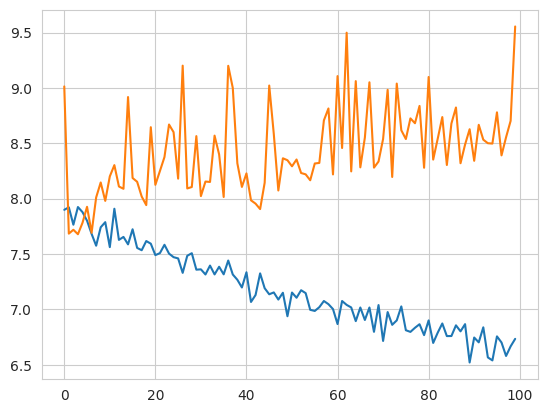

In [305]:
hist_df = pd.DataFrame(history.history)
hist_df["loss"].plot();
hist_df["val_loss"].plot();

In [295]:
y_pred = model.predict(test_data)

4/4 [==============================] - 0s 2ms/step


In [297]:
y_true = test_labels#.to_numpy()

In [299]:
np.mean(np.abs(y_true-y_pred))

9.493005663484208